In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))


from desc import set_device
set_device("cpu")

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

import desc
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_3d,plot_comparison, plot_section, plot_fsa, plot_surfaces, plot_grid
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid
from desc.profiles import PowerSeriesProfile

from desc.backend import jnp
from desc.compute import get_params, get_profiles, get_transforms
from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives.normalization import compute_scaling_factors
from desc.magnetic_fields._core import biot_savart_general

DESC version 0.11.1+570.g83f76bccf,using JAX backend, jax version=0.4.25, jaxlib version=0.4.25, dtype=float64
Using device: CPU, with 10.66 GB available memory


In [2]:
eq = get("precise_QA")
# eq.pressure = 0
# eq.solve();

In [3]:
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.backend import fori_loop

grid_source = LinearGrid(rho=1, M=240, N=240, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=0.3, M=4, N=0, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "phi",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)

# surface element, must divide by NFP to remove the NFP multiple on the
# surface grid weights, as we account for that when doing the for loop
# over NFP
_dV = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
# _dV = grid_source.weights / grid_source.NFP

coord = jnp.vstack((data_eval["R"], data_eval["phi"], data_eval["Z"])).T
_rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T

coord = rpz2xyz(coord)
# _rs = rpz2xyz_vec(_rs, phi=data_source["phi"])
_K = data_source["K_vc"]
print(coord.shape, _rs.shape, _K.shape)
# print(_rs)
# print(data_eval["X"])
# plot_grid(grid_eval);
# print(grid_source.nodes[:, 2])

(9, 3) (231361, 3) (231361, 3)


In [4]:
def nfp_loop(j, f):
    # calculate (by rotating) rs, rs_t, rz_t
    phi = (grid_source.nodes[:, 2] + j * 2 * jnp.pi / grid_source.NFP) % (
        2 * jnp.pi
    )
    # new coords are just old R,Z at a new phi (bc of discrete NFP symmetry)
    rs = jnp.vstack((_rs[:, 0], phi, _rs[:, 2])).T
    rs = rpz2xyz(rs)
    K = rpz2xyz_vec(_K, phi=phi)
    fj = biot_savart_general(
        coord,
        rs,
        K,
        _dV,
    )
    f += fj
    return f

Bplasma = fori_loop(0, grid_source.NFP, nfp_loop, jnp.zeros_like(grid_eval.nodes))
Bplasma = xyz2rpz_vec(Bplasma, phi=data_eval["phi"])
Bplasma *= -1
print(Bplasma.shape)
print(Bplasma)

(9, 3)
[[-1.15484934e-15  9.61198149e-01 -3.01546825e-01]
 [-7.79075172e-02  9.66625822e-01 -3.00865922e-01]
 [-1.24461642e-01  9.80632955e-01 -3.04732639e-01]
 [-1.15044544e-01  9.97715360e-01 -3.20130412e-01]
 [-4.70315257e-02  1.00995643e+00 -3.37486512e-01]
 [ 4.70315257e-02  1.00995643e+00 -3.37486512e-01]
 [ 1.15044544e-01  9.97715360e-01 -3.20130412e-01]
 [ 1.24461642e-01  9.80632955e-01 -3.04732639e-01]
 [ 7.79075172e-02  9.66625822e-01 -3.00865922e-01]]


In [7]:
%pdb

Automatic pdb calling has been turned ON


In [7]:
from desc.magnetic_fields import field_line_integrate, ToroidalMagneticField

from desc.backend import jnp

def B_from_K_trace(re, params=None, basis="rpz",source_grid=grid_source):
    phi_re = re[:, 1]
    re = rpz2xyz(re)
    def nfp_loop(j, f):
        # calculate (by rotating) rs, rs_t, rz_t
        phi = (grid_source.nodes[:, 2] + j * 2 * jnp.pi / grid_source.NFP) % (
            2 * jnp.pi
        )
        # new coords are just old R,Z at a new phi (bc of discrete NFP symmetry)
        rs = jnp.vstack((_rs[:, 0], phi, _rs[:, 2])).T
        rs = rpz2xyz(rs)
        
        K = rpz2xyz_vec(_K, phi=phi)
        fj = biot_savart_general(
            re,
            rs,
            K,
            _dV,
        )
        f += fj
        return f

    Bplasma = fori_loop(0, grid_source.NFP, nfp_loop, jnp.zeros_like(re))
    Bplasma = xyz2rpz_vec(Bplasma, phi=phi_re)
    return Bplasma

ntransit=50

phis = np.arange(0, ntransit * 2 * np.pi, 2 * np.pi)
n_R_points = 10
rrr = np.linspace(1.17,1.25,n_R_points) # initial R positions of field-lines to trace
Bfield = ToroidalMagneticField(1,1)
Bfield.compute_magnetic_field = B_from_K_trace
field_R, field_Z = field_line_integrate(rrr, np.zeros_like(rrr), phis, Bfield, source_grid=grid_source)

In [5]:
Btest = B_from_K_trace(jnp.array([[1.25,0,0]]))

In [6]:
Btest.shape

(9, 3)

/home/yigit/Codes/DESC/desc/utils.py:495: FutureWarning: argument zeta has been renamed to phi, zeta will be removed in a future release
  warnings.warn(


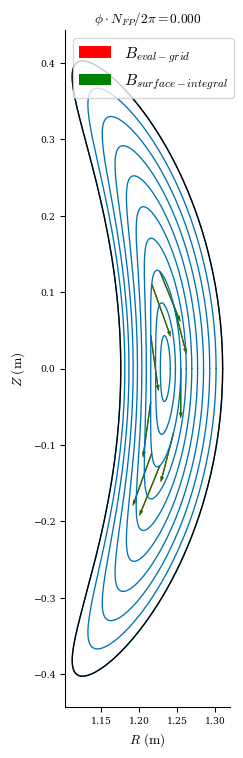

In [ ]:
scale = 1
fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1), zeta=0.0,figsize=(8,8),lcfs_color="k")
# ax[0].quiver(data_source["R"],data_source["Z"],data_source["B"][:,0],data_source["B"][:,2],label=r"$B_{original}$",scale=scale,color="b")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].legend(fontsize=12)
fig=plt.gcf()